In [1]:
import scipy.io as sio
from scipy.fft import fft, fftfreq, fftshift
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
mat=u'rawTracePerson1.mat'
data=sio.loadmat(mat)

In [3]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Track', 'dataTrial'])

In [4]:
data['__header__']

b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Wed Jun 17 10:45:43 2020'

In [5]:
data['__version__']


'1.0'

In [6]:
data['__globals__']

[]

In [7]:
data['Track']

array([[18, 16, 16, 17,  8, 12, 19, 18, 10, 15, 20, 18,  9, 15, 18, 19,
        13, 12,  6,  2,  7, 16, 12, 12, 13, 11, 10,  5,  9,  2,  5,  5,
         2, 10,  2,  4,  1,  3,  8,  5]], dtype=uint8)

In [8]:
data['Track'].shape

(1, 40)

Track是40个trial对应的图片编号。<11的编号为记忆过的图片，>10的是没有记忆过的。

In [9]:
data['dataTrial'].shape

(2100, 40, 19)

Here you can change channel and trail

In [77]:
channel=8
trail=40

In [78]:
trail_1_ch = data['dataTrial'][:,trail-1,channel-1]
y=trail_1_ch

def FFT (data,Fs):
    sp=fftshift(fft(data))/len(data)
    freq= fftshift(fftfreq(len(data),1/Fs))
    if len(freq)/2 <= int(len(freq)/2):
        return freq[-int(len(freq)/2):], np.abs(sp)[-int(len(freq)/2):] 
    else:
        return freq[(-int(len(freq)/2))-1:], np.abs(sp)[-int(len(freq)/2)-1:]

Text(0.5, 1.0, 'Original wave')

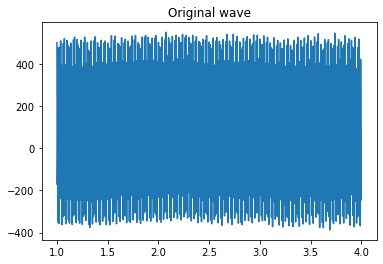

In [79]:
t1=1
t2=4
delta_t=t2-t1
plt.plot(np.linspace(t1,t2,int(300*delta_t)),y[int(300*t1):int(300*t2)])   
plt.title('Original wave')


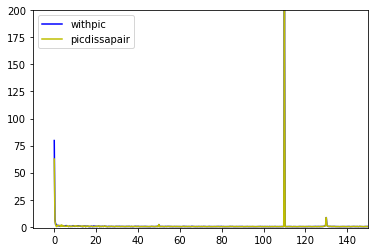

In [110]:
t1,t2=0,3
y_t1_t2_period = y[int(300*t1):int(300*t2)]
Fs=300
Fre1, FFT_y1 = FFT(y_t1_t2_period,Fs)
plt.figure
plt.plot(Fre1,FFT_y1,"-b")
# plt.axis([-1,10,-10,300])

t3,t4=4,7
y_t3_t4_period = y[int(300*t3):int(300*t4)]

Fre2, FFT_y2 = FFT(y_t3_t4_period,Fs)
plt.plot(Fre2,FFT_y2,"-y")
plt.axis([-10,150,-1,200])
plt.legend(['withpic', 'picdissapair'], loc='upper left')
plt.show()

In [81]:
if data['Track'][0,trail-1] < 11:   
    print('Trail:', trail ,'is memorized') 
else:
    print('Trail:', trail ,'is not memorized') 

Trail: 40 is memorized


In [82]:
channel = 8
t3,t4=4,7
Fs=300
experiment_times=20
control_times=20
y_all_trail = data['dataTrial'][int(300*t3):int(300*t4), :, channel-1]
y_memory_trail=[]
y_unmemory_trail=[]

for i in range(experiment_times+control_times):
    if data['Track'][0,i] < 11:   
        y_memory_trail.append(y_all_trail[:,i])
    else:
        y_unmemory_trail.append(y_all_trail[:,i])

y_memory_trail = np.array(y_memory_trail).reshape(((t4-t3)*Fs,experiment_times))
y_unmemory_trail = np.array(y_unmemory_trail).reshape(((t4-t3)*Fs,control_times))

Fre = FFT(y_memory_trail[:,0],Fs)[0]

Fy_memory_trail = [FFT(y_memory_trail[:,i],Fs)[1] for i in range(experiment_times)]
Fy_unmemory_trail = [FFT(y_unmemory_trail[:,i],Fs)[1] for i in range(control_times)]

ym=np.concatenate(Fy_memory_trail).reshape(((t4-t3)*Fs//2,-1))
yum=np.concatenate(Fy_unmemory_trail).reshape(((t4-t3)*Fs//2,-1))

df_memory = pd.DataFrame(ym,index=Fre, columns=[str(i) for i in range(1,experiment_times+1)])
df_unmemory = pd.DataFrame(yum,index=Fre, columns=[str(i) for i in range(experiment_times+1,experiment_times+control_times+1)])

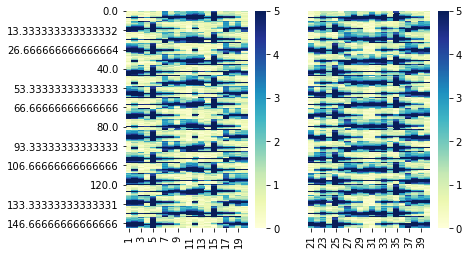

In [83]:
plt.subplot(121)
sns.heatmap(df_memory,vmin=0, vmax=5, cmap="YlGnBu", yticklabels=40)
plt.subplot(122)
sns.heatmap(df_unmemory,vmin=0, vmax=5, cmap="YlGnBu", yticklabels=False)

Trail: 1 is not memorized
Trail: 5 is memorized


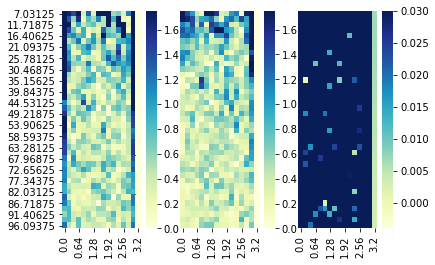

In [152]:
import scipy.signal as signal
channel_1=7
channel_2=19
trail=(1,5)
v_min=0.0
v_max=1.75


if data['Track'][0,trail[0]-1] < 11:   
    print('Trail:', trail[0] ,'is memorized') 
else:
    print('Trail:', trail[0] ,'is not memorized')

if data['Track'][0,trail[1]-1] < 11:   
    print('Trail:', trail[1] ,'is memorized') 
else:
    print('Trail:', trail[1] ,'is not memorized') 

k=sum(data['dataTrial'][900:-300,trail[0]-1,channel-1])/sum(data['dataTrial'][900:-300,trail[1]-1,channel-1])

trail_1_ch = data['dataTrial'][900:-300,trail[0]-1,channel_1-1]-data['dataTrial'][900:-300,trail[0]-1,channel_2-1]
trail_2_ch = data['dataTrial'][900:-300,trail[1]-1,channel_1-1]-data['dataTrial'][900:-300,trail[1]-1,channel_2-1]

f,t,zxx_1 = signal.stft(trail_1_ch, fs=300, nperseg= 128)
f = f[3:42]
zxx_1= np.abs(zxx_1[3:42,:])
# for i in range(16):
#     zxx_1[:, i]/=sum(zxx_1[:, i])


df_stft = pd.DataFrame(np.abs(zxx_1),index=f, columns=t)
plt.subplot(131)
sns.heatmap(df_stft,vmin=v_min, vmax=v_max, cmap='YlGnBu')

plt.subplot(132)
f,t,zxx_2 = signal.stft(trail_2_ch, fs=300, nperseg= 128)
f = f[3:42]
zxx_2= np.abs(zxx_2[3:42,:])
# for i in range(16):
#     zxx_2[:, i]/=sum(zxx_2[:, i])
df_stft = pd.DataFrame(np.abs(zxx_2),index=f, columns=t)
sns.heatmap(df_stft,vmin=v_min, vmax=v_max, yticklabels=False, cmap='YlGnBu')


plt.subplot(133)
zxx = -(zxx_1 - zxx_2)
df_stft = pd.DataFrame(np.abs(zxx),index=f, columns=t)
sns.heatmap(df_stft,vmin=-0.004, vmax=0.03, yticklabels=False, cmap='YlGnBu')